# House Pricing Competition - Kaggle

Jose Valero

## Importing and Gathering Data

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [3]:
#Read the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Target Variable

What we will be predicting will be the prices for the houses in the 'test.csv' data. Therefore, our target variable will be 'SalePrice'.

Let's first have a look at the distribution in of the target variable.

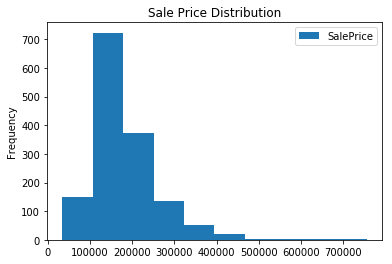

In [30]:
train.plot(kind = 'hist', y = 'SalePrice', title = 'Sale Price Distribution');# Plot a Histogram

We can see that there are some outliers in the Sales price distribution. These outliers might end up affecting the model, so to help our linear regression model, we will log the target variable.

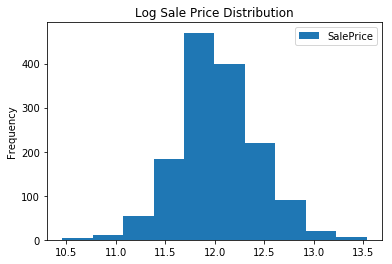

In [32]:
target= train.copy() #Copy the train dataset so we can make changes.
target['SalePrice'] = np.log(target['SalePrice']) # Transform Log the SalePrice variable
target.plot(kind = 'hist', y = 'SalePrice', title = 'Log Sale Price Distribution'); #Creates Histogram

We can now see how the log transformation follows a normal distribution, which will help the linear regression model we will build afterwards. 

After building the model and predicting the house prices, we will need to transform this prices back to normal using the ```exp()``` function.

## Wrangling

## Numerical Variables

We will first look at the numerical variables.

Plots will be shown in groups of 4 for better display

In [729]:
data = train.select_dtypes(include=[np.number]) # It selects only the numerical variables
data.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

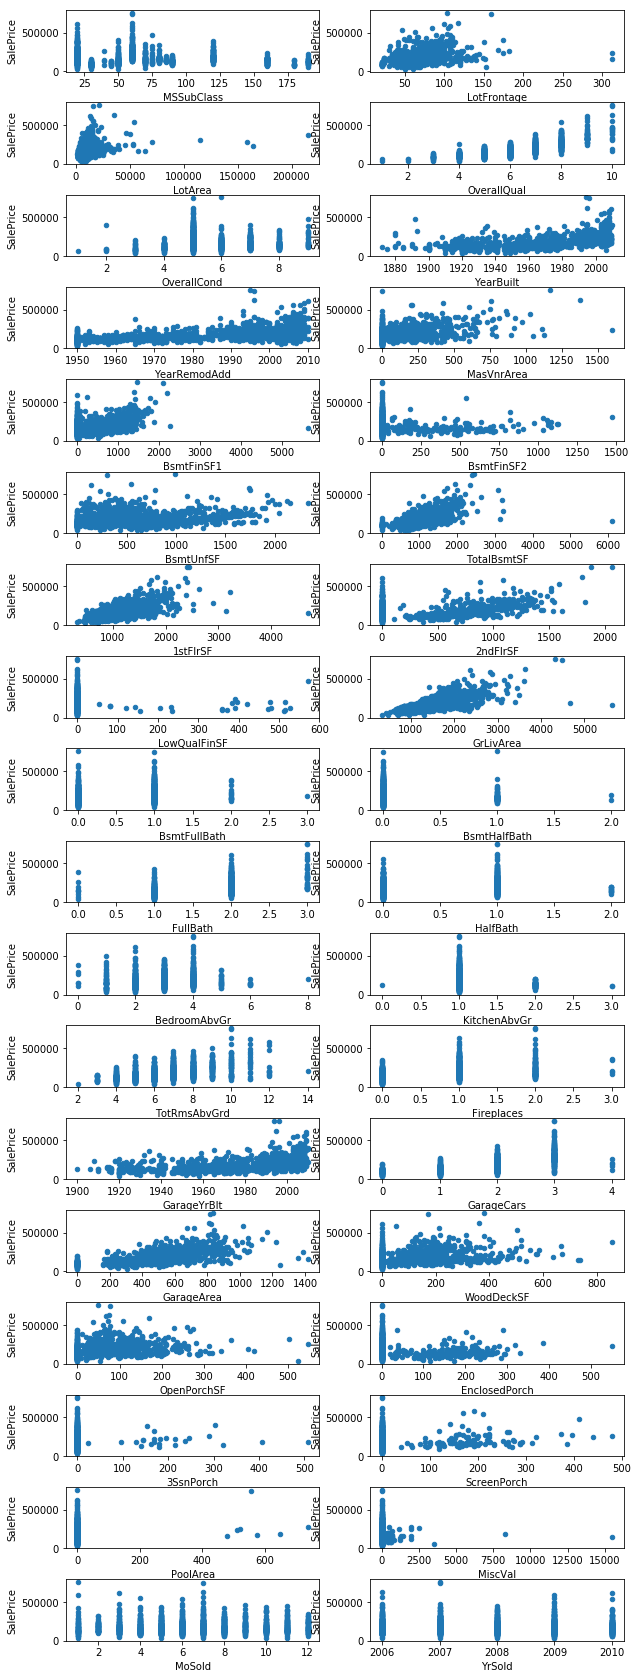

In [730]:
a =data.columns[1:37] #First group of 4. No ID

fig , axes = plt.subplots(nrows= len(a)//2,ncols=2, figsize = (10,30))
fig.subplots_adjust(hspace = 0.5)

for i, variable in enumerate(a):
    data.plot(kind='scatter', x = variable, y = 'SalePrice', ax = axes[i // 2][i % 2])

'LotArea','LotFrontage', 'MasVnrArea','YearBuilt','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch' have some outliers, which should be removed to get more accurate regression model.

In [731]:
train= train[train['LotArea'] < 50000]
train= train[train['LotFrontage'] < 150]
train= train[train['MasVnrArea'] < 750]
train= train[train['YearBuilt'] > 1900]
train= train[train['BsmtUnfSF'] < 2500]
train= train[train['GrLivArea'] < 3500]
train= train[train['GarageArea'] < 1100]
train= train[train['WoodDeckSF'] < 1100]
train= train[train['OpenPorchSF'] < 350]
train= train[train['EnclosedPorch'] < 300]

There are 4 different variables for Basement square feet. I will keep just the Total Basement Square feet.

In [732]:
#removing basement variable not used
train.drop(['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF'], axis =1, inplace=True)
test.drop(['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF'], axis =1, inplace=True)

There is two variable for floor square feet, so we will aggregate both to get a total square feet of the house.

In [733]:
train['total_floor_sqfeet'] = train['1stFlrSF'] + train['2ndFlrSF']
print(train[['1stFlrSF','2ndFlrSF','total_floor_sqfeet']].head())
train.drop(['1stFlrSF','2ndFlrSF'], axis =1, inplace=True)

test['total_floor_sqfeet'] = test['1stFlrSF'] + test['2ndFlrSF']
test.drop(['1stFlrSF','2ndFlrSF'], axis =1, inplace=True)

   1stFlrSF  2ndFlrSF  total_floor_sqfeet
0       856       854                1710
1      1262         0                1262
2       920       866                1786
3       961       756                1717
4      1145      1053                2198


Get rid of the low quality square feet as seems redundant

In [734]:
#Dropping low quality square metre
train.drop(['LowQualFinSF'], axis =1, inplace=True)
test.drop(['LowQualFinSF'], axis =1, inplace=True)

## Non Categorical Values

Let's now focus in the categorial data.

We are now going to check all variable and afterwards choose those one we are going to use in our model.

In [735]:
categorical_data = train.select_dtypes(exclude=[np.number])
categorical_data.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

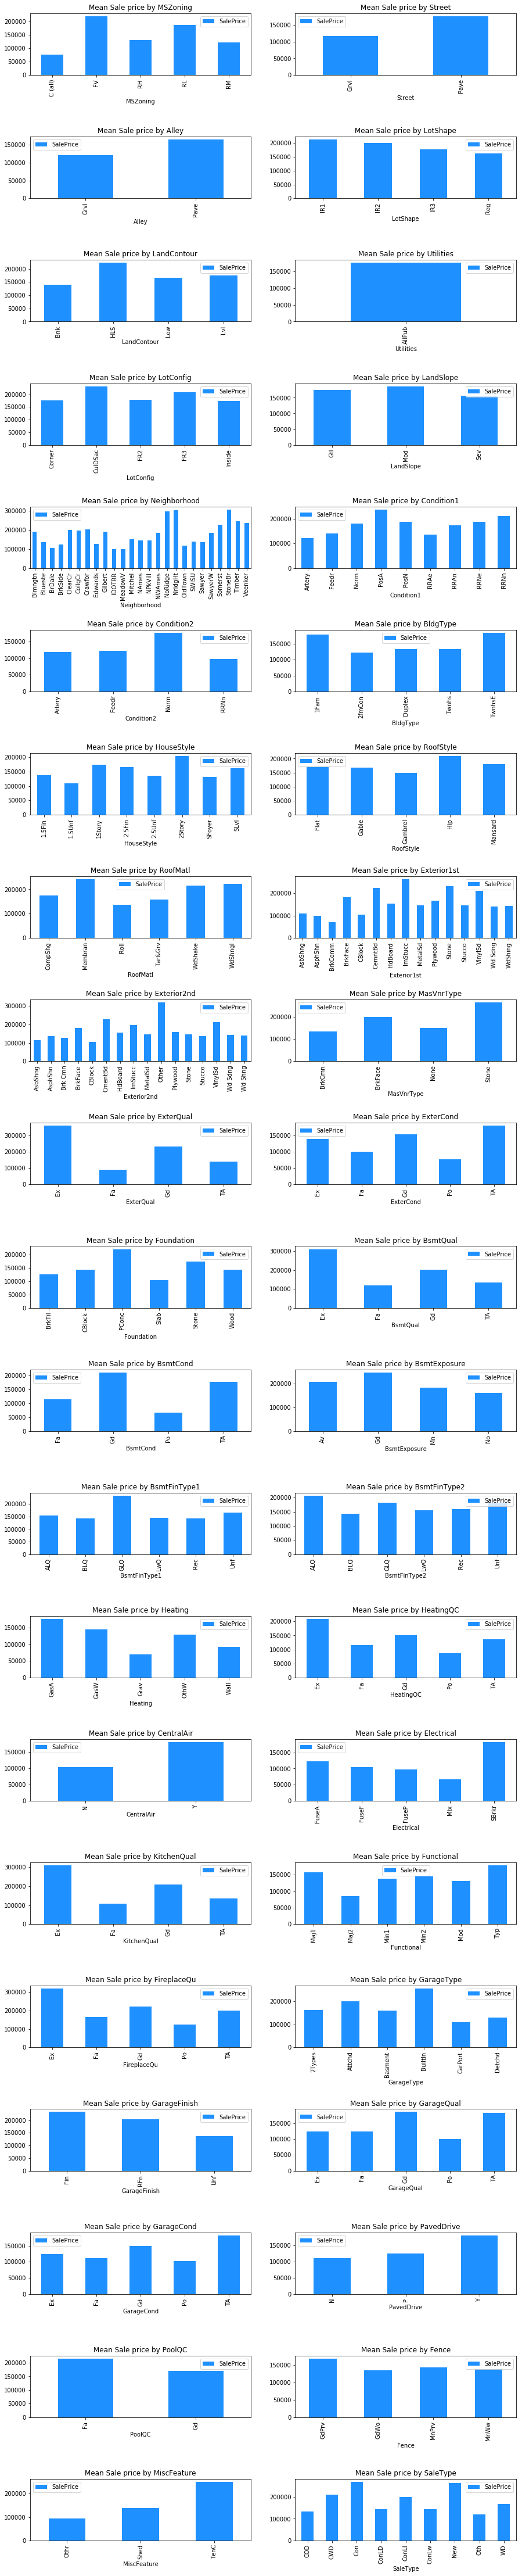

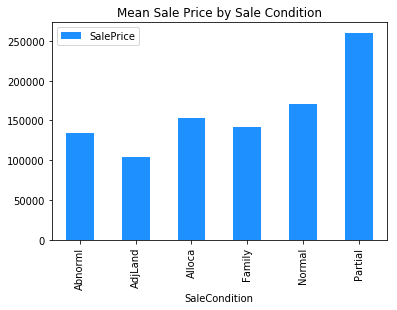

In [736]:
fig, axes = plt.subplots(nrows= 21, ncols=2, figsize=(15,80))

fig.subplots_adjust(hspace = 1)


for i, variable in enumerate(categorical_data.columns[:42]):
    train.pivot_table(values = 'SalePrice', index = variable, ).plot(kind = 'bar', ax = axes[i//2][i%2],
                                                                    title = 'Mean Sale price by {}'.format(variable),
                                                                    color = 'dodgerblue');

train.pivot_table(values = 'SalePrice', index = 'SaleCondition').plot(kind = 'bar',
                                                                      title = 'Mean Sale Price by Sale Condition', 
                                                                      color = 'dodgerblue');

As for the categorical data, I will use in my model:

- Zoning classification (MSZoning): Whether the area is Residencial area or not
- Road access to property (Street): Whether the road is Paved or not (graved)
- Sale Condition: Whether is Partial or not.

#### Area of the propterty



Let's create dummy variable for the type of areas 'MSZoning'.

In [737]:
train= pd.concat([train,pd.get_dummies(train['MSZoning'])], axis =1)
test= pd.concat([test,pd.get_dummies(test['MSZoning'])], axis =1)

Let's encode the variable whether is in a Residential area or not

#### Street Access

Let's encode the Street variable differenciating whether the Street access is Pavemented or not.

In [738]:
def encoding(x): return 1 if x == 'Pave' else 0
train['ecoding_Street'] = train['Street'].apply(encoding)
test['ecoding_Street'] = test['Street'].apply(encoding)

#### Sale Condition

Due to the houses with the sale condition 'Partial' has a significant higher mean value, we will encode the SaleCondition variable between those houses with condition 'Partial' and the rest.

In [739]:
def encoding(x): return 1 if x == 'Partial' else 0
train['econding_SalesCondition'] = train['SaleCondition'].apply(encoding)
test['econding_SalesCondition'] = test['SaleCondition'].apply(encoding)

### Numerical Null values

Let's tackle now the null values from Numerical variables.

In order to solve the issue I have decided to interpolate the null values replacing missing values with the mean for their entire series.

In [740]:
data = train.select_dtypes(include=[np.number])
data = data.interpolate(method = 'linear')
print('There are {} null value in the dataset'.format(data.any().isna().sum()))

There are 0 null value in the dataset


## Building the Model

As we metion in the beggining, we will first do a logarithm transform the target variable, SalesPrice.

In [741]:
train['SalePrice'] = np.log(train['SalePrice'])

We are now ready to separate the variables for modelling.

Id and SalePrice will be removed from the as one is just the index and the other is the target variable.

In [742]:
y = np.log(data['SalePrice'])

X = data.drop(['Id','SalePrice'], axis =1) 

#### Partitioning the data
Now, in order to test our model, we can split the train dataset into two subsets:

- Train (75%)
- Test (25%)

In [743]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

#### Modelling

Let's create our linear regression model using the train data just splitted.

In [744]:
lr = LinearRegression()
model = lr.fit(X_train, y_train)

#### Evaluation

Now we will evaluate how accurate our model is against the test split.

R- square measure how close are the values to the fitted linear regression model we build. 

In [745]:
#R-square
model.score(X_test, y_test)

0.890780209160653

85% of the variance in the Sale Price of the house is explained by the model

Next, we will check the root mean square error (RMSE), which measure the distance between the predicted values and the the actual values.

In [746]:
predictions = model.predict(X_test)
rmse = mean_squared_error(y_test, predictions)

print('The RMSE is {:.2}. Have in mind that this is a log value.'.format(rmse))

The RMSE is 0.017. Have in mind that this is a log value.


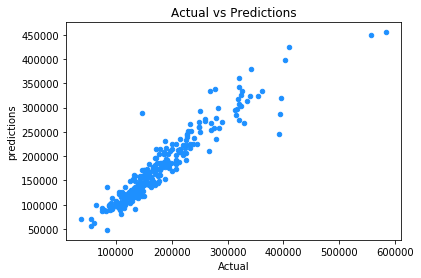

In [747]:
mean_error_plot = pd.DataFrame({'predictions': np.exp(predictions), 'Actual': np.exp(y_test)})
mean_error_plot.plot(kind='scatter', x = 'Actual', y = 'predictions',
                     color = 'dodgerblue', title='Actual vs Predictions');

The plot show a close to a straight line, which tell us that the RMSE is low.

## Submission

We will now use this model to predict the value for the original test dataset. We will then save it in a ```csv``` file and submit it to Kaggle.

We did make the same change to test when wrangling the Train dataset, so we do not need to do more than select the same variable than the model we built for the Train dataset and fill the NAs

In [759]:
features = test.select_dtypes(
        include=[np.number]).drop(['Id'], axis =1).interpolate()

#Selects just the numeric variables (including dummies)
# Fill the null values with the mean value of each serie

In [760]:
submission = pd.DataFrame()
submission['Id'] = test['Id']

In [761]:
predictions = model.predict(features)

final_predictions = np.exp(predictions)

submission['SalePrice'] = final_predictions

In [764]:
submission.to_csv('house_pricing.csv',index=False)